# **Proyecto: API de Análisis de Sentimientos**

##  **Descripción del Proyecto**
**API simple** que recibe textos (comentarios, reseñas o tweets), aplica un **modelo de Data Science** para clasificar el sentimiento y devuelve el resultado en formato **JSON**, permitiendo que las aplicaciones consuman esta predicción automáticamente.

**Clasificación:**
**Binaria**: Positivo / Negativo

**Idioma:** Español
##  **Alcance**
Clasificación con un **modelo simple** usando:
- **TF-IDF**: Técnica que transforma texto en números, mostrando qué palabras son más importantes
- **Regresión Logística optimizada via descenso de gradiente estocástico(SGD Logistic Regression)**: Modelo regresión logística con un rendimiento optimizado.


# **Contenido**
  - Librerías
  - Carga y exploración del dataset
  - Histograma. Distribución de clases
  - Limpieza de datos
    - Uso
  - Tokenización
    - TF-IDF Vectorizador
    - División de 80% entrenamiento / 20% prueba
  - Entrenamiento
    - Regresión Logística
    - Linear SVC
    - Multinomial Naive Bayes
    - Complement Naive Bayes
    - SGDClassifier
  - Evaluación del modelo
    - Métricas
    - Curva ROC / AUC
    - Pruebas rápidas
    - Matriz de confusión + Grafico (Conjunto Entrenamiento)
    -  Matriz de confusión (Conjunto Prueba)
  - Vectorización del vocabulario
  - Verificar que palabras estan más hacia positivo o negativo
    - Palabras más positivas
    - Palabras más negativas
  - Pruebas
    - Transformar la entrada con el vectorizador
    - Mensaje de salida
  - Encapsulamiento del modelo


# Librerias

In [302]:
# Librerías básicas
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re


# NLP / Limpieza de texto
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
!pip install emoji
import emoji


# Vectorización
from sklearn.feature_extraction.text import TfidfVectorizer


# Split y validación
from sklearn.model_selection import train_test_split


# Modelos
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import svm


# Métricas
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    balanced_accuracy_score,
    matthews_corrcoef,
    roc_curve, roc_auc_score
)
from sklearn.model_selection import StratifiedKFold, cross_val_score


In [303]:
# Configurar visualizaciones
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline
print("Librerias cargadas correctamente")

Librerias cargadas correctamente


# Carga y exploración del dataset

In [304]:
import xml.etree.ElementTree as ET
import requests
from io import StringIO
def cargar_tass_desde_url(url):
    """
    Carga el dataset TASS directamente desde una URL

    Args:
        url: URL del archivo XML de TASS

    Returns:
        DataFrame con los tweets procesados
    """
    # print(f"Descargando desde: {url}")

    # Descargar el contenido XML
    response = requests.get(url)
    response.encoding = 'utf-8'  # Importante para caracteres españoles

    if response.status_code != 200:
        raise Exception(f"Error al descargar: {response.status_code}")

    # Parsear el XML
    root = ET.fromstring(response.content)

    # Extraer datos
    tweets_data = []

    for tweet in root.findall('tweet'):
        # Extraer campos
        tweetid = tweet.find('tweetid').text if tweet.find('tweetid') is not None else ''
        user = tweet.find('user').text if tweet.find('user') is not None else ''
        content = tweet.find('content').text if tweet.find('content') is not None else ''
        date = tweet.find('date').text if tweet.find('date') is not None else ''
        lang = tweet.find('lang').text if tweet.find('lang') is not None else ''

        # Extraer sentimiento (puede estar anidado)
        sentiment_elem = tweet.find('sentiment/polarity/value')
        if sentiment_elem is None:
            sentiment_elem = tweet.find('.//value')  # Búsqueda más profunda

        sentiment = sentiment_elem.text if sentiment_elem is not None else 'NONE'

        tweets_data.append({
            'tweet_id': tweetid,
            'user': user,
            'text': content,
            'date': date,
            'lang': lang,
            'sentiment': sentiment
        })

    df = pd.DataFrame(tweets_data)
    # print(f"\nDataset cargado: {len(df)} tweets")
    # print(f"Distribución de sentimientos:\n{df['sentiment'].value_counts()}")

    return df

In [305]:
df1=cargar_tass_desde_url('http://tass.sepln.org/tass_data/dataset/intertass-ES-train-tagged.xml')
df2=cargar_tass_desde_url('http://tass.sepln.org/tass_data/dataset/TASS2019_country_MX_dev.xml')
df3=cargar_tass_desde_url('http://tass.sepln.org/tass_data/dataset/intertass-ES-development-tagged.xml')
df4=cargar_tass_desde_url('http://tass.sepln.org/tass_data/dataset/TASS2019_country_ES_train.xml')
df = pd.concat([df1, df2, df3, df4], ignore_index=True)

In [306]:
df = df[df['text'].notna() & (df['text'] != '')]

# Normalizar etiquetas de sentimiento
# TASS usa: P (Positivo), N (Negativo), NEU (Neutral), NONE (Sin sentimiento)
mapeo_sentimientos = {
    'P': 'positive',
    'N': 'negative',
    'NEU': 'neutral',
    'NONE': 'none'
}

df['label'] = df['sentiment'].map(mapeo_sentimientos)

# Si quieres solo 3 clases (eliminar NONE)
df = df[df['label'] != 'none'].copy()

# Se deja con solo dos clases
df = df[df['label'].isin(['positive', 'negative'])]


In [307]:
print(f"Dataset: \n{df.head(3)}")
print(f"\nShape: {df.shape}")
print(f"\nValores nulos: \n{df.isnull().sum()}")
print(f"\nCantiad de comentarios positivos: {df[df["label"] == "positive"].shape[0]}")
print(f"Cantiad de comentarios neutral: {df[df["label"] == "neutral"].shape[0]}")
print(f"Cantiad de comentarios negativos: {df[df["label"] == "negative"].shape[0]}")

Dataset: 
             tweet_id           user  \
1  768213567418036224       anahorxn   
2  768212591105703936   martitarey13   
3  768221670255493120  endlessmilerr   

                                                text                 date  \
1  @myendlesshazza a. que puto mal escribo\n\nb. ...  2016-08-23 22:29:21   
2  @estherct209 jajajaja la tuya y la d mucha gen...  2016-08-23 22:25:29   
3  Quiero mogollón a @AlbaBenito99 pero sobretodo...  2016-08-23 23:01:33   

  lang sentiment     label  
1   es         N  negative  
2   es         N  negative  
3   es         P  positive  

Shape: (2350, 7)

Valores nulos: 
tweet_id     0
user         0
text         0
date         0
lang         0
sentiment    0
label        0
dtype: int64

Cantiad de comentarios positivos: 987
Cantiad de comentarios neutral: 0
Cantiad de comentarios negativos: 1363


# Histograma. Distribución de clases

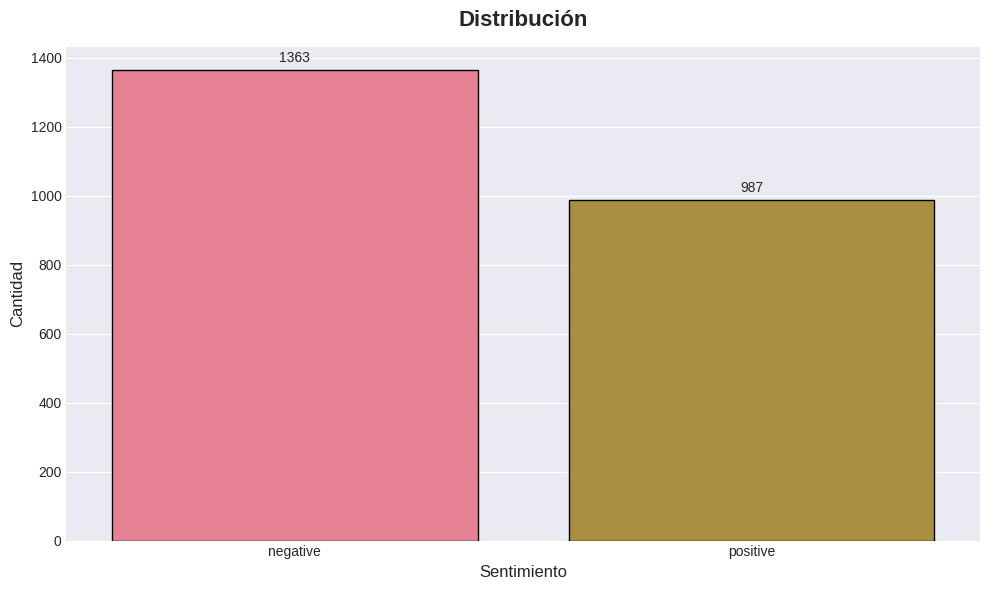

In [308]:
df_hist = pd.DataFrame(df['label'].value_counts())


plt.figure(figsize=(10, 6))

ax = sns.barplot(
    data=df_hist,
    x="label",
    y="count",
    hue="label",
    dodge=False,
    edgecolor="black",
    legend=False
)


ax.set_title(
    "Distribución",
    fontsize=16,
    fontweight="bold",
    pad=15
)

ax.set_xlabel("Sentimiento", fontsize=12)
ax.set_ylabel("Cantidad", fontsize=12)


for container in ax.containers:
    ax.bar_label(container, fmt="%.0f", fontsize=10, padding=4)


plt.tight_layout()

plt.show()

# Limpieza de datos

In [309]:
nltk.download('stopwords') #descarga la lista de palabras vacias por sesion(una vez)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [310]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('spanish'))
stop_words = {
    w.replace("á","a").replace("é","e").replace("í","i")
     .replace("ó","o").replace("ú","u")
    for w in stop_words
}
negaciones = {"no", "ni", "nunca", "jamas"}
stop_words = stop_words - negaciones


def limpieza_datos(tweet):
    texto = emoji.demojize(tweet, delimiters=(" ", " ")).lower()

    # Normalizar repeticiones
    texto = re.sub(r'(.)\1{2,}', r'\1\1', texto)

    # Normalización de jergas
    diccionario = {
    'lol':'reirse mucho',
    'lmao':'reirse mucho',
    'wtf':'que demonios',
    'nmm':'no mames',
    'nmms':'no mames',
    'tqm':'te quiero mucho',
    'rip':'descanse en paz',
    'omg':'oh dios mio',
    'sierto':'cierto',
    'alv':'a la verg',
    'rip':'descanse en paz',
    'gg':'buen juego',
    'wp':'bien jugado',
    'rofl':'revolcarse de risa',
    'nmms':'no mames',
    'npn':'no pasa nada',
    'ntp':'no pasa nada',

    }

    items_ordenados = sorted(diccionario.items(),
                           key=lambda x: len(x[0]),
                           reverse=True)
    for abrev, expansion in items_ordenados:
        patron = r'\b' + re.escape(abrev.strip()) + r'\b'
        texto = re.sub(patron, expansion.strip(), texto, flags=re.IGNORECASE)

    # Quitar tildes
    texto = texto.replace("á", "a")
    texto = texto.replace("é", "e")
    texto = texto.replace("í", "i")
    texto = texto.replace("ó", "o")
    texto = texto.replace("ú", "u")

     # Elimina numeros
    texto = re.sub(r'\d+', '', texto)
    # Elimina urls
    texto = re.sub(r'https?:///\S+|www\.\S+', '', texto)
    # Elimia los @
    texto = re.sub(r'@\w+', '', texto)
    # Elimina el #
    texto = texto.replace("#", "")
    # Normaliza los espacios
    texto = re.sub(r'\s+', ' ', texto)
    palabras = texto.split()
    palabras = [p for p in palabras if p not in stop_words]
    return ' '.join(palabras)


### Uso

In [311]:
df['texto_limpio'] = df['text'].apply(limpieza_datos)
for i in range(1, 5):
  if len(df['texto_limpio'][i]) != len(df['text'][i]):
    print(f"\nTexto original:\n {df['text'][i]}\nTexto limpio:\n {df['texto_limpio'][i]}")


Texto original:
 @myendlesshazza a. que puto mal escribo

b. me sigo surrando help 

3. ha quedado raro el "cómetelo" ahí JAJAJAJA
Texto limpio:
 a. puto mal escribo b. sigo surrando help . quedado raro "cometelo" ahi jajajaja

Texto original:
 @estherct209 jajajaja la tuya y la d mucha gente seguro!! Pero yo no puedo sin mi melena me muero 
Texto limpio:
 jajajaja d mucha gente seguro!! no puedo melena muero

Texto original:
 Quiero mogollón a @AlbaBenito99 pero sobretodo por lo rápido que contesta a los wasaps 
Texto limpio:
 quiero mogollon sobretodo rapido contesta wasaps

Texto original:
 Vale he visto la tia bebiendose su regla y me hs dado muchs grima 
Texto limpio:
 vale visto tia bebiendose regla hs dado muchs grima


# Tokenización

In [312]:
r = df.label.astype("category")
df["code"] = r.cat.codes
df.head(10)

,tweet_id,user,text,date,lang,sentiment,label,texto_limpio,code
1,768213567418036224,anahorxn,@myendlesshazza a. que puto mal escribo\n\nb. ...,2016-08-23 22:29:21,es,N,negative,a. puto mal escribo b. sigo surrando help . qu...,0
2,768212591105703936,martitarey13,@estherct209 jajajaja la tuya y la d mucha gen...,2016-08-23 22:25:29,es,N,negative,jajajaja d mucha gente seguro!! no puedo melen...,0
3,768221670255493120,endlessmilerr,Quiero mogollón a @AlbaBenito99 pero sobretodo...,2016-08-23 23:01:33,es,P,positive,quiero mogollon sobretodo rapido contesta wasaps,1
4,768221021300264964,JunoWTFL,Vale he visto la tia bebiendose su regla y me ...,2016-08-23 22:58:58,es,N,negative,vale visto tia bebiendose regla hs dado muchs ...,0
5,768220253730009091,Alis_8496,@Yulian_Poe @guillermoterry1 Ah. mucho más por...,2016-08-23 22:55:55,es,P,positive,ah. supuesto! solo incluyo. entendido mal,1
6,768224728049999872,caval100,Se ha terminado #Rio2016 Lamentablemente no ar...,2016-08-23 23:13:42,es,N,negative,terminado rio lamentablemente no arriendo gana...,0
7,768231706746912769,mgcsunshine,11. siiii fue super gracioso teniamos que habe...,2016-08-23 23:41:26,es,P,positive,. sii super gracioso habernos sacado foto,1
8,768231229439311872,__LOST_PRINCESS,@toNi_end seria mejor que dejasen de emitir es...,2016-08-23 23:39:32,es,N,negative,mejor dejasen emitir basura evolucionar bien,0
9,768231166965145600,ConLDeLucifer_,"@jonoro96 te mandaria a comprarte un burro, pe...",2016-08-23 23:39:17,es,N,negative,"mandaria comprarte burro, no creo tiendas abie...",0
10,768230914233143296,AranchaGarcia97,Mg y pongo un adjetivo super repelente a vuest...,2016-08-23 23:38:17,es,N,negative,mg pongo adjetivo super repelente nombre,0


## TF-IDF Vectorizador

In [313]:
vectorizer_tf = TfidfVectorizer(
    ngram_range=(1, 3),
    max_features=7000,
    min_df=2,
    max_df=0.85,
    sublinear_tf=True,
    token_pattern=r'\b\w{2,}\b'
)

In [314]:
X_tfidf = vectorizer_tf.fit_transform(df['texto_limpio'])

In [315]:
print(f"\nDimensiones de la matriz TF-IDF: {X_tfidf.shape}")


Dimensiones de la matriz TF-IDF: (2350, 7000)


In [316]:
feature_names = vectorizer_tf.get_feature_names_out()
print(f"\nPrimeros 20 términos: {feature_names[:20]}")


Primeros 20 términos: ['abacos permitidos' 'abacos permitidos mayoria' 'abajo' 'abajo jodido'
 'abajo jodido preciosa' 'abandonado' 'abandonado tw' 'abandone'
 'abandone pais' 'abandone tierra' 'abandone tierra llegue' 'abiertas'
 'abiertas ahora' 'abiertas noviembre' 'abierto' 'abrazarte' 'abrazo'
 'absolutamente' 'abuelo' 'aburrida']


## Division de 80% entrenamiento y 20% pueba

In [317]:
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X_tfidf,
    df['code'],
    df.index,
    test_size=0.2,
    random_state=42,
    stratify=df['code']
)
print(f" X_train: {X_train.shape} texto (80%)")
print(f" X_test: {X_test.shape} texto (20%)")
print(f" y_train: {y_train.shape} etiquetas")
print(f" y_test: {y_test.shape} etiquetas")

 X_train: (1880, 7000) texto (80%)
 X_test: (470, 7000) texto (20%)
 y_train: (1880,) etiquetas
 y_test: (470,) etiquetas


# Entrenamiento

In [318]:
print("Entrenar el modelo con datos TF-IDF..")
print(f" Texto: {X_train.shape[0]}")
print(f" Caracteristicas: {X_train.shape[1]}")
print(f" Etiquetas: {len(y_train)}")

Entrenar el modelo con datos TF-IDF..
 Texto: 1880
 Caracteristicas: 7000
 Etiquetas: 1880


In [319]:
# Modelo baseline
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=5)
dummy_clf.fit(X_train, y_train)


y_pred = dummy_clf.predict(X_test)

# Evaluación
print("Accuracy (Dummy Baseline):", accuracy_score(y_test, y_pred))
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))

Accuracy (Dummy Baseline): 0.5808510638297872

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.58      1.00      0.73       273
           1       0.00      0.00      0.00       197

    accuracy                           0.58       470
   macro avg       0.29      0.50      0.37       470
weighted avg       0.34      0.58      0.43       470



## Regresión Logística

In [320]:
log_reg = LogisticRegression(
    max_iter=1000,
    random_state=42,          # 42 quedo como el random state o semilla
    class_weight="balanced",  # Esto balancea las clases
    solver="liblinear"
)

log_reg.fit(X_train, y_train)
print("Modelo entrenado ")

print("Informacion basica del modelo entrenado")
print(f" Clases aprendidas: {log_reg.classes_}")
print(f" Iteraciones: {log_reg.n_iter_[0]}")


Modelo entrenado 
Informacion basica del modelo entrenado
 Clases aprendidas: [0 1]
 Iteraciones: 4


## Linear SVC

In [321]:
#Svm #1
svm_1 = LinearSVC(
    C=0.2,
    class_weight='balanced',
    random_state=42
)

svm_1.fit(X_train, y_train)
print("Modelo entrenado ")

print("Informacion basica del modelo entrenado")
print(f" Clases aprendidas: {svm_1.classes_}")

Modelo entrenado 
Informacion basica del modelo entrenado
 Clases aprendidas: [0 1]


In [322]:
#Svm # 2
svm_2 = svm.SVC(
    kernel='linear',
    C=1.5,              # Parámetro de regularización
    random_state=42,
    class_weight='balanced'  # Balancea clases desbalanceadas
)

svm_2.fit(X_train, y_train)
print("Modelo entrenado exitosamente!")

Modelo entrenado exitosamente!


## Multinomial Naive Bayes

In [323]:
nb = MultinomialNB(alpha=0.5)
nb.fit(X_train, y_train)
print("Modelo entrenado ")

print("\n3. Informacion basica del modelo entrenado")
print(f" Clases aprendidas: {nb.classes_}")

Modelo entrenado 

3. Informacion basica del modelo entrenado
 Clases aprendidas: [0 1]


## Complement Naive Bayes


In [324]:
# Complement Naive Bayes
cnb = ComplementNB(alpha=0.1)
cnb.fit(X_train, y_train)
print("Modelo entrenado ")

print("\n3. Informacion basica del modelo entrenado")
print(f" Clases aprendidas: {cnb.classes_}")

Modelo entrenado 

3. Informacion basica del modelo entrenado
 Clases aprendidas: [0 1]


## SGDClassifier

In [325]:
# Como SVM
sgd_SVM = SGDClassifier(
    loss='hinge',
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)
sgd_SVM.fit(X_train, y_train)
print("Modelo entrenado ")

print("Informacion basica del modelo entrenado")
print(f" Clases aprendidas: {sgd_SVM.classes_}")

Modelo entrenado 
Informacion basica del modelo entrenado
 Clases aprendidas: [0 1]


In [326]:
# Como Regresión Lógistica
sgd_Log = SGDClassifier(
    loss='log_loss',
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)
sgd_Log.fit(X_train, y_train)
print("Modelo entrenado ")

print("Informacion basica del modelo entrenado")
print(f" Clases aprendidas: {sgd_Log.classes_}")
print("ENTRENAMIENTO COMPLETADO")

Modelo entrenado 
Informacion basica del modelo entrenado
 Clases aprendidas: [0 1]
ENTRENAMIENTO COMPLETADO


# **Evaluación**

Se evalua cada modelo en:  
   - Accuracy
   - Precision
   - Recall
   - F1-score
   - F1_Macro-score
   - MCC-score  

Y su matriz de confusión.

In [327]:
#Función para evaluar el módelo y mostrar todas las métricas.
def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    # Hacemos predicciones
    y_pred = modelo.predict(X_test)

    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="binary", pos_label=1, zero_division=0)
    recall = recall_score(y_test, y_pred, average='binary', pos_label=1, zero_division=0)
    f1 = f1_score(y_test, y_pred, average='binary', pos_label=1, zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    mcc = matthews_corrcoef(y_test, y_pred)

    # Imprimir resultados
    print(f"\n Resultados de {nombre_modelo}:")
    print(f"   - Accuracy  : {accuracy:.4f}")
    print(f"   - Precision : {precision:.4f}")
    print(f"   - Recall    : {recall:.4f}")
    print(f"   - F1-score  : {f1:.4f}")
    print(f"   - F1_Macro-score  : {f1_macro:.4f}")
    print(f"   - MCC-score  : {mcc:.4f}")

    # Matriz de confusión
    # cm = confusion_matrix(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    labels = sorted(list(set(y_test)))

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=False,
                xticklabels=labels,
                yticklabels=labels)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(f"Matriz de confusión - {nombre_modelo}")
    plt.show()

    return


 Resultados de Regresión Logística:
   - Accuracy  : 0.8702
   - Precision : 0.8617
   - Recall    : 0.8223
   - F1-score  : 0.8416
   - F1_Macro-score  : 0.8658
   - MCC-score  : 0.7323


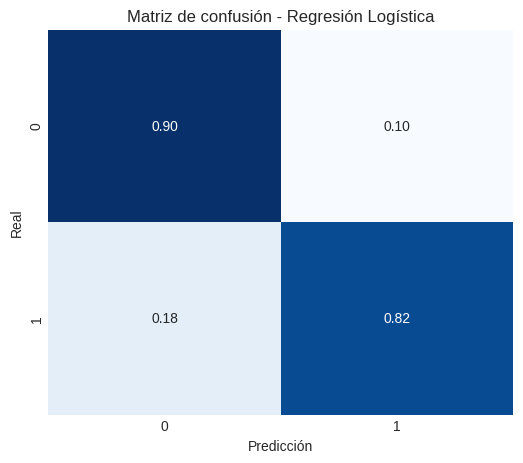

In [328]:
evaluar_modelo(log_reg, X_test, y_test, "Regresión Logística")


 Resultados de SVM #1:
   - Accuracy  : 0.8766
   - Precision : 0.8798
   - Recall    : 0.8173
   - F1-score  : 0.8474
   - F1_Macro-score  : 0.8719
   - MCC-score  : 0.7455


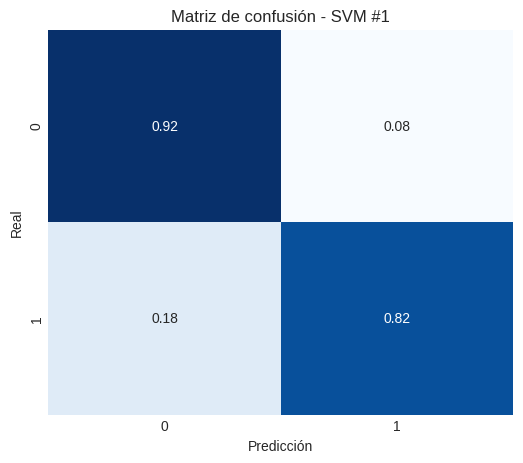

In [329]:
evaluar_modelo(svm_1, X_test, y_test, "SVM #1")


 Resultados de SVM #2:
   - Accuracy  : 0.8723
   - Precision : 0.8663
   - Recall    : 0.8223
   - F1-score  : 0.8438
   - F1_Macro-score  : 0.8679
   - MCC-score  : 0.7367


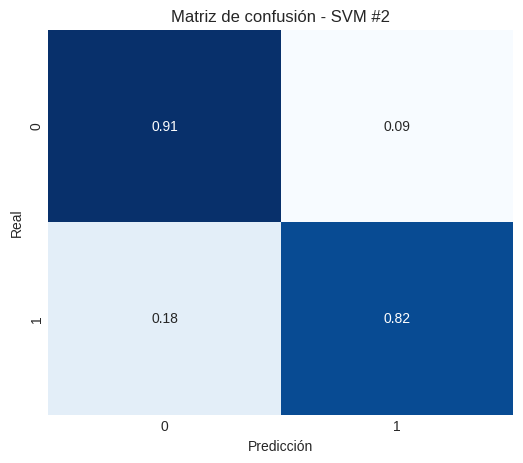

In [330]:
evaluar_modelo(svm_2, X_test, y_test, "SVM #2")


 Resultados de Naive Bayes:
   - Accuracy  : 0.8681
   - Precision : 0.9355
   - Recall    : 0.7360
   - F1-score  : 0.8239
   - F1_Macro-score  : 0.8592
   - MCC-score  : 0.7340


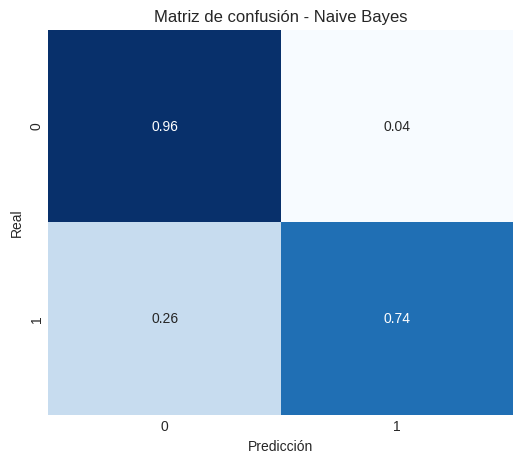

In [331]:
evaluar_modelo(nb, X_test, y_test, "Naive Bayes")


 Resultados de Complement Naive Bayes:
   - Accuracy  : 0.8638
   - Precision : 0.8482
   - Recall    : 0.8223
   - F1-score  : 0.8351
   - F1_Macro-score  : 0.8596
   - MCC-score  : 0.7194


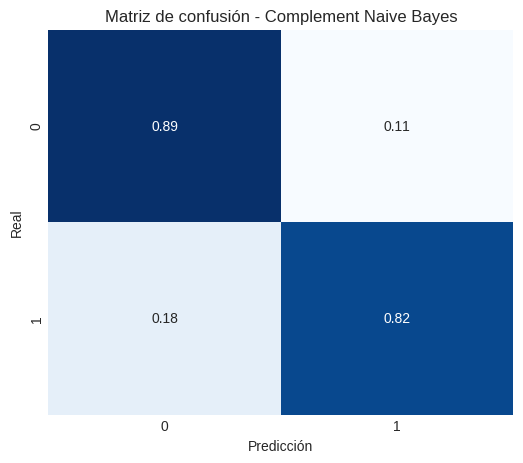

In [332]:
evaluar_modelo(cnb, X_test, y_test, "Complement Naive Bayes")


 Resultados de SGDClassifier como SVM:
   - Accuracy  : 0.8851
   - Precision : 0.8994
   - Recall    : 0.8173
   - F1-score  : 0.8564
   - F1_Macro-score  : 0.8803
   - MCC-score  : 0.7634


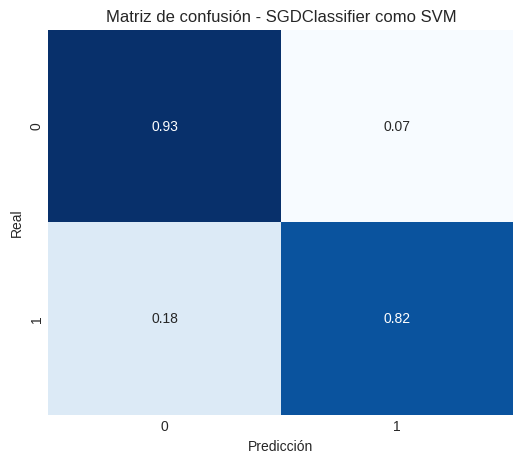

In [333]:
evaluar_modelo(sgd_SVM, X_test, y_test, "SGDClassifier como SVM")


 Resultados de SGDClassifier como Regresión Logística:
   - Accuracy  : 0.8766
   - Precision : 0.8798
   - Recall    : 0.8173
   - F1-score  : 0.8474
   - F1_Macro-score  : 0.8719
   - MCC-score  : 0.7455


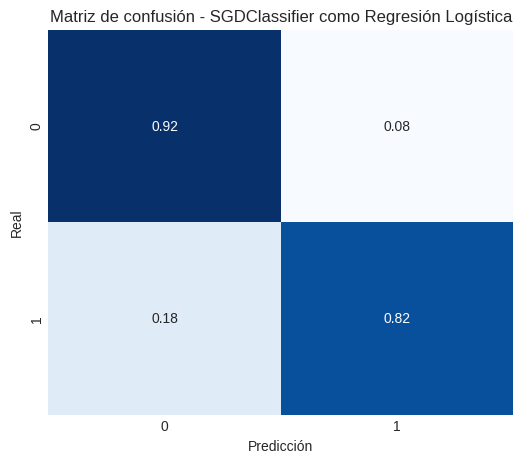

In [334]:
evaluar_modelo(sgd_Log, X_test, y_test, "SGDClassifier como Regresión Logística")

**Mejor modelo:** *SGDClassifier como Regresión Logística*
   - Accuracy  : 0.8766
   - Precision : 0.8798
   - Recall    : 0.8173
   - F1-score  : 0.8474
   - F1_Macro-score  : 0.8719
   - MCC-score  : 0.7455

## Curva ROC/AUC

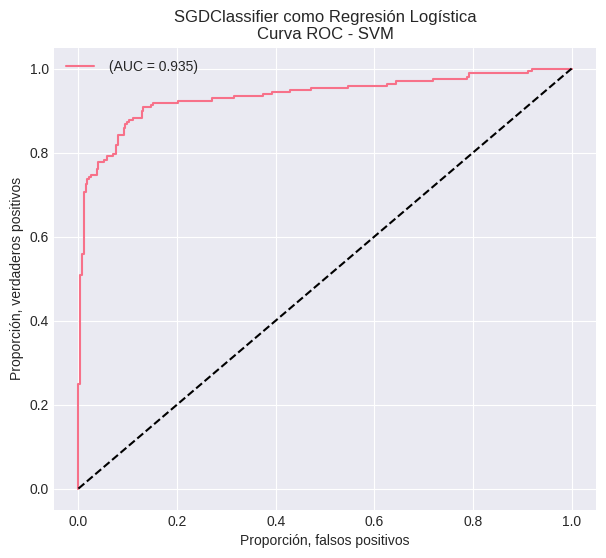

In [335]:
y_score = sgd_Log.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score)
auc = roc_auc_score(y_test, y_score)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f" (AUC = {auc:.3f})")
plt.plot([0,1], [0,1], 'k--')

plt.xlabel("Proporción, falsos positivos")
plt.ylabel("Proporción, verdaderos positivos")
plt.title("SGDClassifier como Regresión Logística\nCurva ROC - SVM")
plt.legend()
plt.grid(True)
plt.show()


In [336]:
cv = StratifiedKFold(5)
scores = cross_val_score(
    sgd_Log,
    X_train,
    y_train,
    cv=cv,
    scoring='roc_auc'
)

print("AUC promedio:", scores.mean())

AUC promedio: 0.8908314945999303


## Pruebas

In [337]:
def predecir_sentimiento(texto):
    # Transformar el texto usando el vectorizador ya entrenado
    texto_vectorizado = vectorizer_tf.transform([texto])
    prediccion = sgd_Log.predict(texto_vectorizado)

    # Obtener probabilidades y la confianza para la clase predicha
    probabilidades = cnb.predict_proba(texto_vectorizado)
    confianza = probabilidades[0, prediccion[0]]

    return prediccion[0], confianza

In [338]:
print("\n" + "="*50)
print("PREDICCIONES DE EJEMPLO")
print("="*50)

ejemplo = [
    'Esa Camisa está muy bonita',
    '@user Que horrible le queda esa falda fea.',
    'No entiendo pq dices eso',
    "La ps2 demostrando por que es la mejor consola que ha sacado sony, me alegra muchísimo haber tenido una 😌",
    "@user la mitología de por sí es maravillosa 😍 pero es tan cara la colección  y son 60 tomos 😫",
    "El final fue tan malo que los fans no lo aceptaron. Fue incluso peor que la reacción que tuvieron los fans de GoT.",
    "Que bueno que existan medios críticos que cuestionan y analizan",
    "Magistral la explicación , excelente que los medios den cobertura a estas simples normas de protección","Me encanta cómo los productos de Apple funcionan sin complicaciones 😍 Excelente diseño y rendimiento.",
    "El servicio al cliente de esta aerolínea es pésimo: retrasos, cero explicaciones y ninguna empatía 😡✈️",
    "La nueva reforma educativa parece un paso en la dirección correcta, ya era necesaria 📚👍",
    "No confío en los políticos que prometen de todo en campaña y luego desaparecen 🙄"

]
for texto in ejemplo:
    sentimiento, confianza = predecir_sentimiento(texto)
    print(f"\nTexto: '{texto}'")
    match sentimiento:
      case 0:
        print(f"Sentimiento: Negativo")
      case 1:
        print(f"Sentimiento: Positivo")
    print(f"Confianza: {confianza:.2f}")


PREDICCIONES DE EJEMPLO

Texto: 'Esa Camisa está muy bonita'
Sentimiento: Positivo
Confianza: 0.87

Texto: '@user Que horrible le queda esa falda fea.'
Sentimiento: Negativo
Confianza: 0.97

Texto: 'No entiendo pq dices eso'
Sentimiento: Negativo
Confianza: 0.77

Texto: 'La ps2 demostrando por que es la mejor consola que ha sacado sony, me alegra muchísimo haber tenido una 😌'
Sentimiento: Positivo
Confianza: 0.26

Texto: '@user la mitología de por sí es maravillosa 😍 pero es tan cara la colección  y son 60 tomos 😫'
Sentimiento: Negativo
Confianza: 0.77

Texto: 'El final fue tan malo que los fans no lo aceptaron. Fue incluso peor que la reacción que tuvieron los fans de GoT.'
Sentimiento: Negativo
Confianza: 0.98

Texto: 'Que bueno que existan medios críticos que cuestionan y analizan'
Sentimiento: Positivo
Confianza: 0.63

Texto: 'Magistral la explicación , excelente que los medios den cobertura a estas simples normas de protección'
Sentimiento: Positivo
Confianza: 0.31

Texto: 'Me en

## Matriz de confusión + Grafico (Conjunto Entrenamiento)

 Mejor modelo seleccionado: SGDClassifier como Regresión Logística
 Basado en : 
   - F1-Score: 0.8474 (mas alto)
   - Accuracy: 0.8766 (mas alto)
   - MCC: 0.7455 (mas alto)
   - Balance: Precision 0.8798, Recall 0.8173

Matriz de confusión - conjunto entrenamiento
Modelo: SGDClassifier como Regresión Logística
Matriz de confusión: 

[TN=0.9844036697247707  FP=0.015596330275229359]
 [FN=0.006329113924050633 TP=0.9936708860759493]


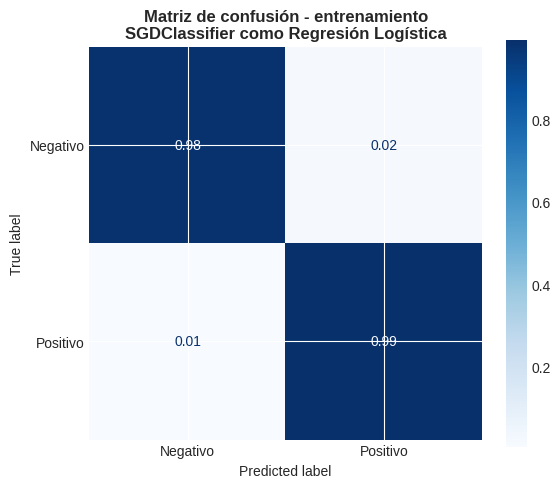


Reporte de clasificación - entrenamiento
              precision    recall  f1-score   support

    Negativo       1.00      0.98      0.99      1090
    Positivo       0.98      0.99      0.99       790

    accuracy                           0.99      1880
   macro avg       0.99      0.99      0.99      1880
weighted avg       0.99      0.99      0.99      1880



In [339]:
#predecir con el mejor modelo se usara "SGDClassifier como Regresión Logística"

mejor_modelo_nombre = "SGDClassifier como Regresión Logística"
mejor_modelo = sgd_Log

print(f" Mejor modelo seleccionado: {mejor_modelo_nombre}")
print(f" Basado en : ")
print(f"   - F1-Score: 0.8474 (mas alto)")
print(f"   - Accuracy: 0.8766 (mas alto)")
print(f"   - MCC: 0.7455 (mas alto)")
print(f"   - Balance: Precision 0.8798, Recall 0.8173")

print("\n" + "="*60)
print("Matriz de confusión - conjunto entrenamiento")
print(f"Modelo: {mejor_modelo_nombre}")

#predecir en entrenamiento
y_train_pred = mejor_modelo.predict(X_train)
cm_train = confusion_matrix(y_train, y_train_pred,normalize="true")

print(f"Matriz de confusión: ")
print(f"\n[TN={cm_train[0,0]}  FP={cm_train[0,1]}]")
print(f" [FN={cm_train[1,0]} TP={cm_train[1,1]}]")


#Graficar
fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Negativo','Positivo'])
disp.plot(ax=ax, cmap='Blues', values_format='.2f')
ax.set_title(f'Matriz de confusión - entrenamiento\n{mejor_modelo_nombre}', fontweight='bold')
plt.tight_layout()
plt.show()

print("\nReporte de clasificación - entrenamiento")
print(classification_report(y_train, y_train_pred, target_names=['Negativo', 'Positivo']))


## Matriz de confusión (Conjunto Prueba)

Modelo: SGDClassifier como Regresión Logística

Matriz de Confusión (Prueba)
           Prediccion
            Negativo Positivo
Real Negativo  0.92      0.080586
     Positivo  0.182741      0.817259

Verificación con tus resultados:
Accuracy calculado:  0.8683
Precision calculada: 0.9102 
Recall calculado:    0.8173
diferencia de redondeo


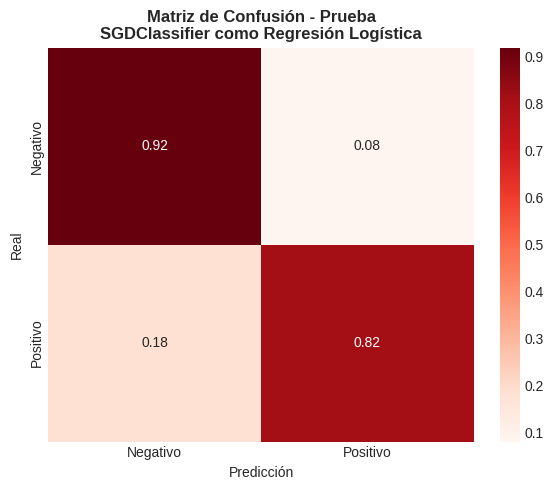


Reporte de clasificación - entrenamiento
              precision    recall  f1-score   support

    Negativo       0.87      0.92      0.90       273
    Positivo       0.88      0.82      0.85       197

    accuracy                           0.88       470
   macro avg       0.88      0.87      0.87       470
weighted avg       0.88      0.88      0.88       470



In [340]:
# Calcular matriz de confusion de PRUEBA


y_test_pred = mejor_modelo.predict(X_test)
cm_test = confusion_matrix(y_test, y_test_pred, normalize="true")

print(f"Modelo: {mejor_modelo_nombre}")
print(f"\nMatriz de Confusión (Prueba)")
print("           Prediccion")
print("            Negativo Positivo")
print(f"Real Negativo  {cm_test[0,0]:.2f}      {cm_test[0,1]:2f}")
print(f"     Positivo  {cm_test[1,0]:2f}      {cm_test[1,1]:2f}")

# Verificar que coincida con los datos de test
total_prueba = cm_test.sum()
accuracy_calculado = (cm_test[0,0] + cm_test[1,1]) / total_prueba
precision_calculada = cm_test[1,1] / (cm_test[1,1] + cm_test[0,1]) if (cm_test[1,1] + cm_test[0,1]) > 0 else 0
recall_calculado = cm_test[1,1] / (cm_test[1,1] + cm_test[1,0]) if (cm_test[1,1] + cm_test[1,0]) > 0 else 0

print(f"\nVerificación con tus resultados:")
print(f"Accuracy calculado:  {accuracy_calculado:.4f}")
print(f"Precision calculada: {precision_calculada:.4f} ")
print(f"Recall calculado:    {recall_calculado:.4f}")

if abs(accuracy_calculado - 0.7235) < 0.001:
    print("Coinciden")
else:
    print("diferencia de redondeo")

#Grafico
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='.2f', cmap='Reds',
           xticklabels=['Negativo', 'Positivo'],
           yticklabels=['Negativo', 'Positivo'],
           ax=ax)
ax.set_title(f'Matriz de Confusión - Prueba\n{mejor_modelo_nombre}', fontweight='bold')
ax.set_xlabel('Predicción')
ax.set_ylabel('Real')
plt.tight_layout()
plt.show()
print("\nReporte de clasificación - entrenamiento")
print(classification_report(y_test, y_test_pred, target_names=['Negativo', 'Positivo']))


# Vectorización del vocabulario


1. Informacion del Vectorizador TF-IDF:
   * Numero total de características: 7000
   * Tamaño del vocabulario: 7000
   * Configuracion usada:
     - max_features: 7000
     - min_df: 2
     - max_df: 0.85
     - ngram_range: (1, 3)

2. Ejemplos de caracteristicas (primeras 50):
['abacos permitidos' 'abacos permitidos mayoria' 'abajo' 'abajo jodido'
 'abajo jodido preciosa' 'abandonado' 'abandonado tw' 'abandone'
 'abandone pais' 'abandone tierra' 'abandone tierra llegue' 'abiertas'
 'abiertas ahora' 'abiertas noviembre' 'abierto' 'abrazarte' 'abrazo'
 'absolutamente' 'abuelo' 'aburrida' 'acaba' 'acabado' 'acabar' 'acabaron'
 'acabe' 'acabo' 'acabo bueno' 'acabo poner' 'acordarse' 'acoso'
 'acostumbrarse' 'actitud' 'actriz' 'acuerdo' 'adaptacion' 'ademas'
 'adolescentes' 'adolescentes mierda' 'agosto' 'agua' 'ah' 'ah no' 'ahi'
 'ahora' 'ahora mismo' 'ahora no' 'ahorita' 'ai' 'aire' 'alba']

3. Ejemplos de caracteristicas (últimas 50):
['viernes' 'violencia' 'vista' 'visto' 'viva' 'viv

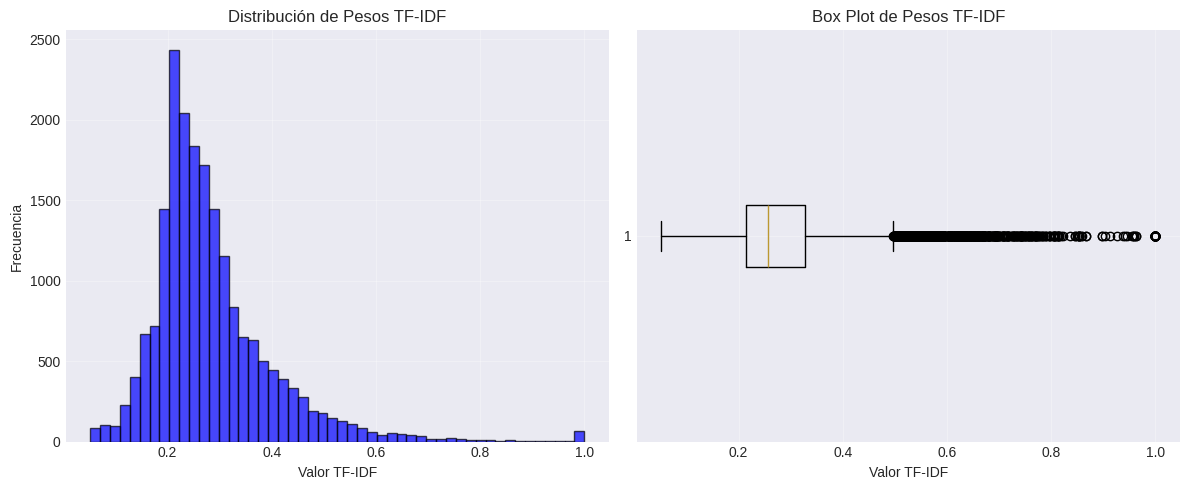


   Estadísticas descriptivas de pesos TF-IDF:
     * Mínimo: 0.0516
     * Máximo: 1.0000
     * Media: 0.2845
     * Mediana: 0.2574
     * Desviación estándar: 0.1167

9. Densidad de la matriz TF-IDF:
   * Conjunto entrenamiento: 0.001502 (0.1502%)
   * Conjunto prueba: 0.001454 (0.1454%)
   * Promedio de elementos no cero por documento: 10.5


In [341]:
#Obtener información del vectorizador TF-IDF
print("\n1. Informacion del Vectorizador TF-IDF:")
print(f"   * Numero total de características: {len(vectorizer_tf.get_feature_names_out())}")
print(f"   * Tamaño del vocabulario: {vectorizer_tf.vocabulary_.__len__()}")
print(f"   * Configuracion usada:")
print(f"     - max_features: {vectorizer_tf.max_features}")
print(f"     - min_df: {vectorizer_tf.min_df}")
print(f"     - max_df: {vectorizer_tf.max_df}")
print(f"     - ngram_range: {vectorizer_tf.ngram_range}")

#Mostrar algunas caracteristicas importantes
print("\n2. Ejemplos de caracteristicas (primeras 50):")
caracteristicas = vectorizer_tf.get_feature_names_out()
print(caracteristicas[:50])

print("\n3. Ejemplos de caracteristicas (últimas 50):")
print(caracteristicas[-50:])

#Estadisticas del vocabulario
print("\n4. Estadisticas del vocabulario:")

# Contar tipos de tokens (unigramas vs bigramas)
unigramas = sum(1 for palabra in caracteristicas if ' ' not in palabra)
bigramas = sum(1 for palabra in caracteristicas if ' ' in palabra)
print(f"   * Unigramas (palabras individuales): {unigramas}")
print(f"   * Bigramas (pares de palabras): {bigramas}")
print(f"   * Proporcion unigramas/bigramas: {unigramas/bigramas:.2f}")

#Mostrar palabras mas frecuentes segun IDF
print("\n5. Top 20 palabras con mayor IDF (mas especificas):")

# Obtener idf scores
idf_scores = vectorizer_tf.idf_

# Crear dataframe con palabras y sus idf
idf_df = pd.DataFrame({
    'palabra': caracteristicas,
    'idf_score': idf_scores
})
# Ordenar por idf (mayor idf = mas especifica)
top_idf = idf_df.sort_values('idf_score', ascending=False).head(20)
for i, (_, row) in enumerate(top_idf.iterrows(), 1):
    print(f"   {i:2d}. {row['palabra']:20s} - IDF: {row['idf_score']:.4f}")

#Mostrar palabras con menor IDF (mas comunes)
print("\n6. Top 20 palabras con menor IDF (más comunes):")
bottom_idf = idf_df.sort_values('idf_score', ascending=True).head(20)
for i, (_, row) in enumerate(bottom_idf.iterrows(), 1):
    print(f"   {i:2d}. {row['palabra']:20s} - IDF: {row['idf_score']:.4f}")

#Ejemplos de transformacion TF-IDF
print("\n7. Ejemplo de transformacion TF-IDF:")
ejemplo_texto = "Me gusta mucho este programa, es excelente!"
ejemplo_limpio = limpieza_datos(ejemplo_texto)
ejemplo_vectorizer_tf = vectorizer_tf.transform([ejemplo_limpio])

print(f"   Texto original: {ejemplo_texto}")
print(f"   Texto limpio: {ejemplo_limpio}")
print(f"   Forma del vector TF-IDF: {ejemplo_vectorizer_tf.shape}")
print(f"   Numero de elementos no cero: {ejemplo_vectorizer_tf.nnz}")

# Mostrar las caracteristicas con mayor peso para este ejemplo
print(f"\n   Palabras mas importantes para este texto:")
indices_no_cero = ejemplo_vectorizer_tf.nonzero()[1]
valores = ejemplo_vectorizer_tf.data
palabras_ejemplo = [(caracteristicas[idx], val) for idx, val in zip(indices_no_cero, valores)]
palabras_ejemplo.sort(key=lambda x: x[1], reverse=True)

for palabra, peso in palabras_ejemplo[:10]:
    print(f"     • {palabra:20s} - Peso: {peso:.4f}")

#Grafico de distribución de pesos TF-IDF
print("\n8. Distribucion de pesos TF-IDF en el conjunto de entrenamiento:")
# Calcular estadisticas de los pesos
pesos_entrenamiento = X_train.data

plt.figure(figsize=(12, 5))

# Histograma de pesos
plt.subplot(1, 2, 1)
plt.hist(pesos_entrenamiento, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribución de Pesos TF-IDF')
plt.xlabel('Valor TF-IDF')
plt.ylabel('Frecuencia')
plt.grid(alpha=0.3)

# Box plot
plt.subplot(1, 2, 2)
plt.boxplot(pesos_entrenamiento, vert=False)
plt.title('Box Plot de Pesos TF-IDF')
plt.xlabel('Valor TF-IDF')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

#Estadísticas descriptivas
print(f"\n   Estadísticas descriptivas de pesos TF-IDF:")
print(f"     * Mínimo: {pesos_entrenamiento.min():.4f}")
print(f"     * Máximo: {pesos_entrenamiento.max():.4f}")
print(f"     * Media: {pesos_entrenamiento.mean():.4f}")
print(f"     * Mediana: {np.median(pesos_entrenamiento):.4f}")
print(f"     * Desviación estándar: {pesos_entrenamiento.std():.4f}")

#Densidad de la matriz TF-IDF
print("\n9. Densidad de la matriz TF-IDF:")
densidad_entrenamiento = X_train.nnz / (X_train.shape[0] * X_train.shape[1])
densidad_prueba = X_test.nnz / (X_test.shape[0] * X_test.shape[1])

print(f"   * Conjunto entrenamiento: {densidad_entrenamiento:.6f} ({densidad_entrenamiento*100:.4f}%)")
print(f"   * Conjunto prueba: {densidad_prueba:.6f} ({densidad_prueba*100:.4f}%)")
print(f"   * Promedio de elementos no cero por documento: {X_train.nnz / X_train.shape[0]:.1f}")

# Verificar que palabras estan más hacia positivo o negativo

In [342]:
import random
# Verificar si el modelo tiene coeficientes para analisis

if hasattr(mejor_modelo, 'coef_'):
    # Obtener coeficientes del modelo para representa el "peso" de una palabra
    coeficientes = mejor_modelo.coef_[0]
    caracteristicas = vectorizer_tf.get_feature_names_out()

    # Crear DataFrame para analisis
    coef_df = pd.DataFrame({
        'palabra': caracteristicas,
        'coeficiente': coeficientes
    })

    print(f" Modelo analizable: {type(mejor_modelo).__name__}")
    print(f" Total de palabras en vocabulario: {len(coeficientes)}")
    print(f" Rango de coeficientes: [{coeficientes.min():.4f}, {coeficientes.max():.4f}]")
    print(f" Media de coeficientes: {coeficientes.mean():.4f}")

    #Contar distribucion basica
    positivas = sum(coeficientes > 0)
    negativas = sum(coeficientes < 0)
    neutras = sum(coeficientes == 0)

    print(f"\nDistribucion de polaridad:")
    print(f"  * Palabras positivas (coef > 0): {positivas} ({positivas/len(coeficientes)*100:.1f}%)")
    print(f"  * Palabras negativas (coef < 0): {negativas} ({negativas/len(coeficientes)*100:.1f}%)")

    #Mostrar algunas palabras aleatorias con sus coeficientes
    print(f"\nEjemplos aleatorios de polaridad:")
    print("-" * 50)


    random_indices = random.sample(range(len(coeficientes)), 10)
    for idx in random_indices:
        palabra = caracteristicas[idx]
        coef = coeficientes[idx]
        polaridad = "POSITIVO" if coef > 0 else "NEGATIVO" if coef < 0 else "NEUTRO"
        print(f"  {palabra:20s} → {coef:7.4f} ({polaridad})")

else:
    print(" El modelo seleccionado no permite analisis de coeficientes")
    print("  Tipo de modelo:", type(mejor_modelo).__name__)

 Modelo analizable: SGDClassifier
 Total de palabras en vocabulario: 7000
 Rango de coeficientes: [-7.0444, 5.3038]
 Media de coeficientes: 0.0180

Distribucion de polaridad:
  * Palabras positivas (coef > 0): 3181 (45.4%)
  * Palabras negativas (coef < 0): 3636 (51.9%)

Ejemplos aleatorios de polaridad:
--------------------------------------------------
  hizo                 → -1.7400 (NEGATIVO)
  bien dicho           →  0.4747 (POSITIVO)
  buenos consejos      →  0.5618 (POSITIVO)
  padres               → -0.5493 (NEGATIVO)
  libro                →  1.6580 (POSITIVO)
  nubes                →  0.1916 (POSITIVO)
  infinito casa        →  0.3677 (POSITIVO)
  hoy torneo liga      → -0.3704 (NEGATIVO)
  oie                  →  0.5441 (POSITIVO)
  haceis               →  0.2650 (POSITIVO)


## Palabras más positivas


TOP 20 PALABRAS MAS POSITIVAS:
---------------------------------------------
 1. feliz                     →  5.3038
 2. gracias                   →  4.8191
 3. buena                     →  4.3169
 4. genial                    →  4.2974
 5. bueno                     →  3.1244
 6. preciosa                  →  3.0994
 7. encanta                   →  2.9527
 8. mejor                     →  2.9438
 9. tranquilo                 →  2.8136
10. besitos                   →  2.7806
11. puedes                    →  2.7520
12. buenos dias               →  2.7449
13. muchas gracias            →  2.6049
14. guapa                     →  2.5249
15. jajaja                    →  2.4599
16. escribo                   →  2.3503
17. buen                      →  2.3388
18. fiestas                   →  2.2736
19. mañana                    →  2.2716
20. bien                      →  2.2587

Analisis de palabras positivas:
  * Coeficiente mas alto: 5.3038
  * Coeficiente promedio (top 20): 3.0516


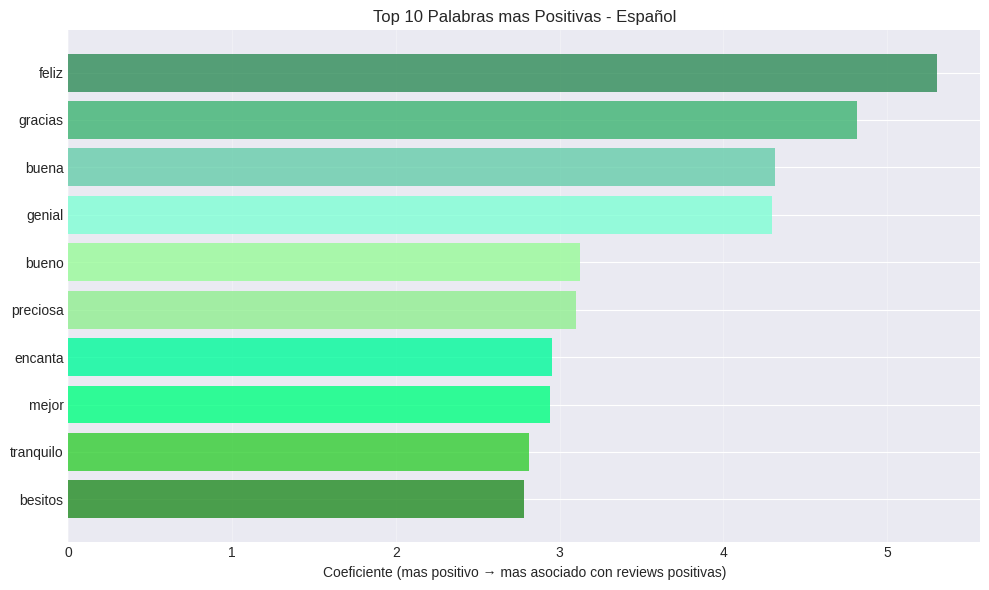

In [343]:
if hasattr(mejor_modelo, 'coef_'):
    # Ordenar por coeficiente descendente (más positivo primero)
    palabras_positivas = coef_df.sort_values('coeficiente', ascending=False)

    print("\nTOP 20 PALABRAS MAS POSITIVAS:")
    print("-" * 45)

    #Mostrar top 20
    for i, (_, row) in enumerate(palabras_positivas.head(20).iterrows(), 1):
        print(f"{i:2d}. {row['palabra']:25s} → {row['coeficiente']:7.4f}")

    #Analisis de palabras positivas
    print(f"\nAnalisis de palabras positivas:")
    print(f"  * Coeficiente mas alto: {palabras_positivas.iloc[0]['coeficiente']:.4f}")
    print(f"  * Coeficiente promedio (top 20): {palabras_positivas.head(20)['coeficiente'].mean():.4f}")

    #Grafico de palabras mas positivas
    plt.figure(figsize=(10, 6))
    top_10_pos = palabras_positivas.head(10)

    plt.barh(range(len(top_10_pos)),
             top_10_pos['coeficiente'].values,
             color=['#2E8B57', '#3CB371', '#66CDAA', '#7FFFD4', '#98FB98',
                    '#90EE90', '#00FA9A', '#00FF7F', '#32CD32', '#228B22'],
             alpha=0.8)

    plt.yticks(range(len(top_10_pos)), top_10_pos['palabra'].values)
    plt.gca().invert_yaxis()
    plt.xlabel('Coeficiente (mas positivo → mas asociado con reviews positivas)')
    plt.title('Top 10 Palabras mas Positivas - Español')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

## Palabras más negativas


TOP 20 PALABRAS MAS NEGATIVAS:
---------------------------------------------
 1. no                        → -7.0444
 2. triste                    → -3.7642
 3. odio                      → -2.9981
 4. peor                      → -2.9172
 5. dificil                   → -2.7916
 6. siento                    → -2.7571
 7. ni                        → -2.6952
 8. puto                      → -2.5159
 9. pobre                     → -2.3865
10. sad                       → -2.3110
11. da                        → -2.2906
12. feo                       → -2.2890
13. pa                        → -2.2813
14. pues                      → -2.2701
15. puta                      → -2.1593
16. raro                      → -2.1507
17. quedar                    → -2.1143
18. mierda                    → -2.0915
19. unico                     → -2.0489
20. extraño                   → -2.0369

Analisis de palabras negativas:
  * Coeficiente mas bajo: -7.0444
  * Coeficiente promedio (top 20): -2.6957


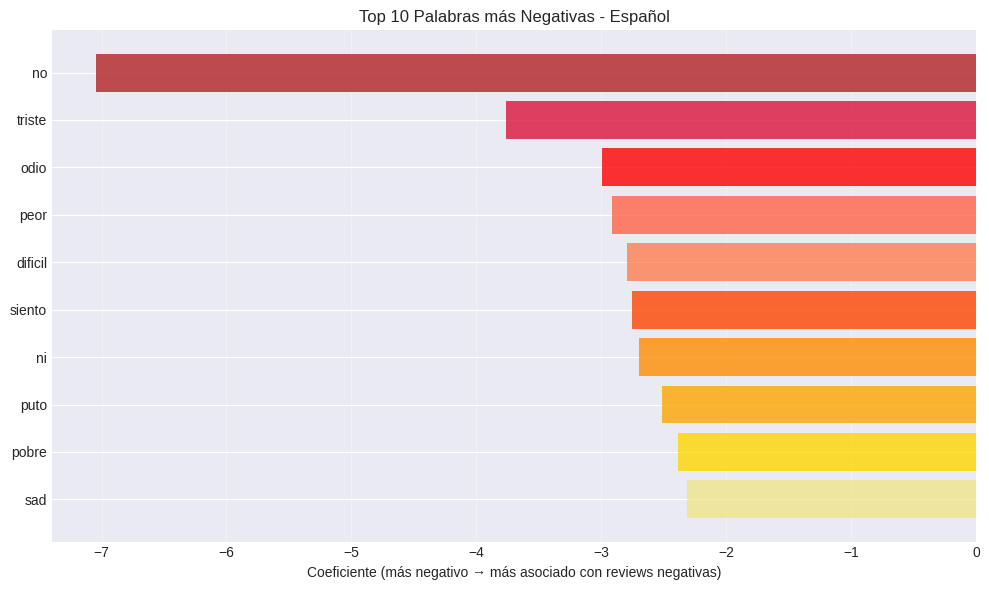

In [344]:
if hasattr(mejor_modelo, 'coef_'):
    # Ordenar por coeficiente ascendente (más negativo primero)
    palabras_negativas = coef_df.sort_values('coeficiente', ascending=True)

    print("\nTOP 20 PALABRAS MAS NEGATIVAS:")
    print("-" * 45)

    # Mostrar top 20
    for i, (_, row) in enumerate(palabras_negativas.head(20).iterrows(), 1):
        print(f"{i:2d}. {row['palabra']:25s} → {row['coeficiente']:7.4f}")

    # Analisis de palabras negativas
    print(f"\nAnalisis de palabras negativas:")
    print(f"  * Coeficiente mas bajo: {palabras_negativas.iloc[0]['coeficiente']:.4f}")
    print(f"  * Coeficiente promedio (top 20): {palabras_negativas.head(20)['coeficiente'].mean():.4f}")

    # Grafico de palabras mas negativas
    plt.figure(figsize=(10, 6))
    top_10_neg = palabras_negativas.head(10)

    plt.barh(range(len(top_10_neg)),
             top_10_neg['coeficiente'].values,
             color=['#B22222', '#DC143C', '#FF0000', '#FF6347', '#FF7F50',
                    '#FF4500', '#FF8C00', '#FFA500', '#FFD700', '#F0E68C'],
             alpha=0.8)

    plt.yticks(range(len(top_10_neg)), top_10_neg['palabra'].values)
    plt.gca().invert_yaxis()
    plt.xlabel('Coeficiente (más negativo → más asociado con reviews negativas)')
    plt.title('Top 10 Palabras más Negativas - Español')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Prueba

In [345]:
prueba = ["Es irrespetuoso y crítico sin ofrecer soluciones constructivas",
           "Toma desiciones que parece beneficiar solo sus  propios intereses",
           "La evaluación fue satisfactoria, y el evaluador demostró un rendimiento óptimo",
          "El evaluador respondio adecuadamente mis dudas"]

print("Textos de prueba en español:")
print("-" * 50)
for i, texto in enumerate(prueba, 1):
    print(f"{i}. {texto}")

# Aplicar limpieza
prueba_limpia = [limpieza_datos(texto) for texto in prueba]

print("\nTextos despues de limpieza:")
print("-" * 50)
for i, texto in enumerate(prueba_limpia, 1):
    print(f"{i}. {texto}")

#Transformar con TF-IDF (Español)
prueba_vectorizer_tf = vectorizer_tf.transform(prueba_limpia)

print(f"\nInformacion de la transformacion:")
print(f"* Forma: {prueba_vectorizer_tf.shape}")
print(f"* Elementos no cero: {prueba_vectorizer_tf.nnz}")
print(f"* Densidad: {prueba_vectorizer_tf.nnz / (prueba_vectorizer_tf.shape[0] * prueba_vectorizer_tf.shape[1]) * 100:.2f}%")


Textos de prueba en español:
--------------------------------------------------
1. Es irrespetuoso y crítico sin ofrecer soluciones constructivas
2. Toma desiciones que parece beneficiar solo sus  propios intereses
3. La evaluación fue satisfactoria, y el evaluador demostró un rendimiento óptimo
4. El evaluador respondio adecuadamente mis dudas

Textos despues de limpieza:
--------------------------------------------------
1. irrespetuoso critico ofrecer soluciones constructivas
2. toma desiciones parece beneficiar solo propios intereses
3. evaluacion satisfactoria, evaluador demostro rendimiento optimo
4. evaluador respondio adecuadamente dudas

Informacion de la transformacion:
* Forma: (4, 7000)
* Elementos no cero: 4
* Densidad: 0.01%


# Transformar la entrada con el vectorizador

In [346]:
print("Resumen de la transformacion:")
print(f"1. Textos originales: {len(prueba)} textos")
print(f"2. Textos limpios: {len(prueba_limpia)} textos")
print(f"3. Vector TF-IDF creado: {prueba_vectorizer_tf.shape}")
print(f"   * 4 documentos (filas)")
print(f"   * 1962 caracteristicas (columnas - palabras/emojis)")
print(f"   * 3 elementos no cero (palabras reconocidas del vocabulario)")
print(f"   * Densidad: 0.04% (matriz muy dispersa)")

#Mostrar que palabras del vocabulario aparecen en cada texto
print("\nPalabras reconocidas del vocabulario en cada texto:")
caracteristicas = vectorizer_tf.get_feature_names_out()

for i in range(len(prueba_limpia)):
    print(f"\nTexto {i+1}: '{prueba_limpia[i][:50]}...'")

    # Obtener indices de palabras no cero para este documento
    fila = prueba_vectorizer_tf[i]
    indices_no_cero = fila.nonzero()[1]
    valores = fila.data

    if len(indices_no_cero) > 0:
        print(f"  Palabras reconocidas ({len(indices_no_cero)}):")
        for idx, valor in zip(indices_no_cero, valores):
            palabra = caracteristicas[idx]
            print(f"    • {palabra:20s} → TF-IDF: {valor:.4f}")
    else:
        print(f" Ninguna palabra reconocida en el vocabulario")

Resumen de la transformacion:
1. Textos originales: 4 textos
2. Textos limpios: 4 textos
3. Vector TF-IDF creado: (4, 7000)
   * 4 documentos (filas)
   * 1962 caracteristicas (columnas - palabras/emojis)
   * 3 elementos no cero (palabras reconocidas del vocabulario)
   * Densidad: 0.04% (matriz muy dispersa)

Palabras reconocidas del vocabulario en cada texto:

Texto 1: 'irrespetuoso critico ofrecer soluciones constructi...'
  Palabras reconocidas (1):
    • irrespetuoso         → TF-IDF: 1.0000

Texto 2: 'toma desiciones parece beneficiar solo propios int...'
  Palabras reconocidas (2):
    • parece               → TF-IDF: 0.7923
    • solo                 → TF-IDF: 0.6102

Texto 3: 'evaluacion satisfactoria, evaluador demostro rendi...'
 Ninguna palabra reconocida en el vocabulario

Texto 4: 'evaluador respondio adecuadamente dudas...'
  Palabras reconocidas (1):
    • dudas                → TF-IDF: 1.0000


In [347]:
# Predecir con el modelo
P = mejor_modelo.predict(prueba_vectorizer_tf)

print("\nPredicciones del modelo:")
print("-" * 60)

for i in range(len(prueba)):
    pred = P[i]
    sentimiento = "POSITIVO" if pred == 1 else "NEGATIVO"

    print(f"\nTexto {i+1}:")
    print(f"  Texto: '{prueba[i][:50]}...'")
    print(f"  Predicción: {pred} ({sentimiento})")

    # Mostrar probabilidades si están disponibles
    if hasattr(mejor_modelo, 'predict_proba'):
        probs = mejor_modelo.predict_proba(prueba_vectorizer_tf[i])[0]
        print(f"  Probabilidades: Negativo={probs[0]:.3f}, Positivo={probs[1]:.3f}")
        print(f"  Confianza: {max(probs):.1%}")

    # Mostrar palabras clave que influyeron
    print(f"  Palabras reconocidas: {prueba_vectorizer_tf[i].nnz}")


Predicciones del modelo:
------------------------------------------------------------

Texto 1:
  Texto: 'Es irrespetuoso y crítico sin ofrecer soluciones c...'
  Predicción: 0 (NEGATIVO)
  Probabilidades: Negativo=0.617, Positivo=0.383
  Confianza: 61.7%
  Palabras reconocidas: 1

Texto 2:
  Texto: 'Toma desiciones que parece beneficiar solo sus  pr...'
  Predicción: 0 (NEGATIVO)
  Probabilidades: Negativo=0.629, Positivo=0.371
  Confianza: 62.9%
  Palabras reconocidas: 2

Texto 3:
  Texto: 'La evaluación fue satisfactoria, y el evaluador de...'
  Predicción: 0 (NEGATIVO)
  Probabilidades: Negativo=0.535, Positivo=0.465
  Confianza: 53.5%
  Palabras reconocidas: 0

Texto 4:
  Texto: 'El evaluador respondio adecuadamente mis dudas...'
  Predicción: 1 (POSITIVO)
  Probabilidades: Negativo=0.314, Positivo=0.686
  Confianza: 68.6%
  Palabras reconocidas: 1


In [348]:
# Obtener las clases del modelo
clases = mejor_modelo.classes_

print(f"Clases aprendidas por el modelo: {clases}")
print(f"* Índice 0 = {clases[0]} → Negativo")
print(f"* Índice 1 = {clases[1]} → Positivo")

print(f"\nNúmero de clases: {len(clases)}")

Clases aprendidas por el modelo: [0 1]
* Índice 0 = 0 → Negativo
* Índice 1 = 1 → Positivo

Número de clases: 2


# Mensaje de salida

In [349]:

for i in range(len(P)):
    pred_numerica = P[i]
    pred_clase = clases[pred_numerica]

    # Convertir a texto legible
    if pred_numerica == 0:
        texto_pred = "NEGATIVO"
    else:
        texto_pred = "POSITIVO"

    print(f"Texto {i+1}: Prediccion numerica={pred_numerica}, Clase={pred_clase} → {texto_pred}")

Texto 1: Prediccion numerica=0, Clase=0 → NEGATIVO
Texto 2: Prediccion numerica=0, Clase=0 → NEGATIVO
Texto 3: Prediccion numerica=0, Clase=0 → NEGATIVO
Texto 4: Prediccion numerica=1, Clase=1 → POSITIVO


# Encapsulamiento del modelo


In [350]:
import joblib
from nltk.corpus import stopwords
joblib.dump(mejor_modelo, 'modelo_es.pkl')
print("Modelo guardado: modelo_es.pkl")

#Guardar vectorizador
joblib.dump(vectorizer_tf, 'vectorizador_es.pkl')
print("Vectorizador guardado: vectorizador_es.pkl")

#Obtener stopwords como la que usamos
stop_words = set(stopwords.words('spanish'))
stop_words = {
    w.replace("á","a").replace("é","e").replace("í","i")
     .replace("ó","o").replace("ú","u")
    for w in stop_words
}
negaciones = {"no", "ni", "nunca", "jamas"}
stopwords_filtradas_es = stop_words - negaciones

joblib.dump(stopwords_filtradas_es, 'stopwords_es.pkl')
print("Stopwords guardadas: stopwords_es.pkl")

#Guardar método de limpieza
joblib.dump(limpieza_datos, 'limpieza_es.pkl')

print("\n" + "="*50)
print("1. modelo_es.pkl       <- Modelo entrenado")
print("2. vectorizador_es.pkl <- Vectorizador TF-IDF")
print("3. stopwords_es.pkl    <- Stopwords filtradas")
print("3. limpieza_es.pkl     <- Limpieza")

Modelo guardado: modelo_es.pkl
Vectorizador guardado: vectorizador_es.pkl
Stopwords guardadas: stopwords_es.pkl

1. modelo_es.pkl       <- Modelo entrenado
2. vectorizador_es.pkl <- Vectorizador TF-IDF
3. stopwords_es.pkl    <- Stopwords filtradas
3. limpieza_es.pkl     <- Limpieza
